In [1]:
# conda remove pystan fbprophet
# conda conda install -c conda-forge pystan fbprophet

import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pykrx import stock
import os

import datetime
from dateutil.relativedelta import relativedelta

Importing plotly failed. Interactive plots will not work.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


씨젠(096530) 주가: 2016.01.24 ~ 2021.01.24


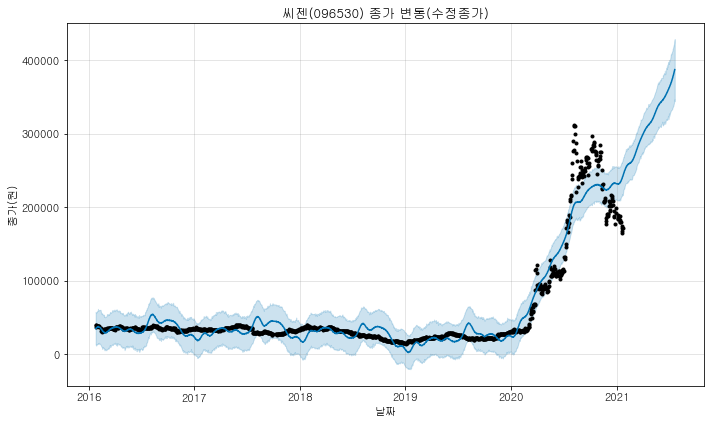

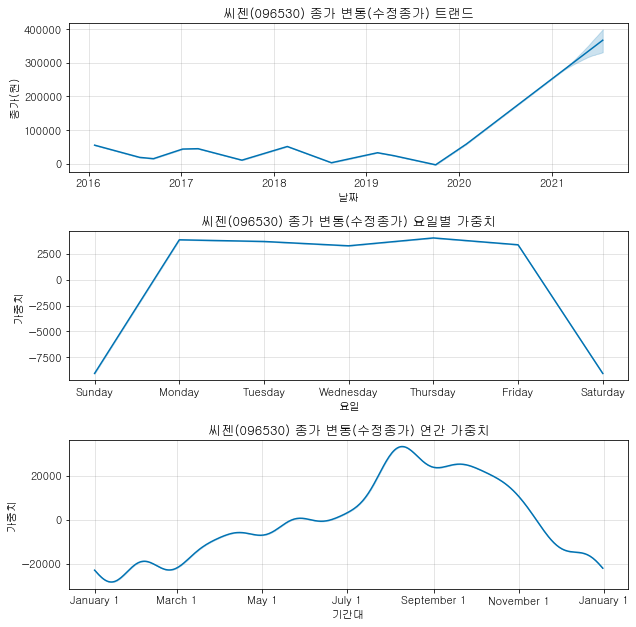

In [25]:
 # 그래프 사전작업
def setKoFont():
    from matplotlib import font_manager, rc
    # font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name() # 음수의 경우 "-" 글자가 깨짐
    #font_name = font_manager.FontProperties(fname="C:\Windows\Fonts\D2Coding.ttf").get_name()
    font_name = "gulim"
    rc("font", family=font_name)
    plt.rcParams["font.size"] = 11
    plt.rcParams["figure.figsize"] = (14, 8)

# 테스트용 데이터(기간, 항목)
## 항목 예시:
## 삼성전자(005930) / 아시아나항공(020560) / 한국조선해양(009540)
# krx_nm = "아시아나항공"
# krx_cd = "020560"

krx_nm = "씨젠"
krx_cd = "096530"


krx_fullnm = krx_nm + "(" + krx_cd + ")"

now = datetime.date.today()
end_dt = now - datetime.timedelta(days=1)
start_dt = end_dt - relativedelta(years=5)
# start_dt = end_dt - datetime.timedelta(weeks=48)

print(krx_fullnm + " 주가: " + start_dt.strftime("%Y.%m.%d") + " ~ " + end_dt.strftime("%Y.%m.%d"))
df_base = stock.get_market_ohlcv_by_date(start_dt.strftime("%Y%m%d"), end_dt.strftime("%Y%m%d"), krx_cd)
# print(df_base.head(10))

df = pd.DataFrame()
df["y"] = df_base["종가"]
df.reset_index(level=0, inplace=True)
df.rename(columns={"날짜":"ds"}, inplace=True)
# print(df.head(10))

# 예측
## no_weekend: fbprophet 예측 목록(future)에서 주말 제거
## 주말 제거 기준: pandas dtype의 weekday 값(0:월 ~ 6:일) ( https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.weekday.html )
## Trand 변경 감지 민감도(Prophet param)는 다음 항목 참고 ( https://zzsza.github.io/data/2019/02/06/prophet/ )
m = Prophet(changepoint_prior_scale=0.1).fit(df)
future = m.make_future_dataframe(periods=180, freq="D")
future_no_weekend = future.copy()
future_no_weekend = future_no_weekend[ future_no_weekend["ds"].dt.weekday < 5 ]
forecast = m.predict(future_no_weekend)
forecast.tail()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(60)

# 그래프 작성
setKoFont()

fig1 = m.plot(forecast)
fig1_axes = fig1.axes
fig1_axes[0].set_title(krx_fullnm + " 종가 변동(수정종가)")
fig1_axes[0].set_xlabel("날짜")
fig1_axes[0].set_ylabel("종가(원)")
fig1.subplots_adjust(top=0.94) # fbprophet에 의해 타이틀 마진 없는 것을 재조정

fig2 = m.plot_components(forecast)
fig2_axes = fig2.axes
fig2_axes[0].set_title(krx_fullnm + " 종가 변동(수정종가) 트랜드")
fig2_axes[0].set_xlabel("날짜")
fig2_axes[0].set_ylabel("종가(원)")
if len(fig2_axes) >= 2:
    fig2_axes[1].set_title(krx_fullnm + " 종가 변동(수정종가) 요일별 가중치")
    fig2_axes[1].set_xlabel("요일")
    fig2_axes[1].set_ylabel("가중치")
if len(fig2_axes) >= 3:
    fig2_axes[2].set_title(krx_fullnm + " 종가 변동(수정종가) 연간 가중치")
    fig2_axes[2].set_xlabel("기간대")
    fig2_axes[2].set_ylabel("가중치")
fig2.subplots_adjust(top=0.94, hspace=0.4)

plt.show()